In [1]:
import os
import sys
os.chdir('..')
sys.path.append('..')

import cv2
import time
import json
import yaml
import torch
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt

from utils.sdf import SDF
from configs.cfgparser import Config

# Enable if you have libiomp5md.dll conflicts (not a permanent fix)
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
with Path("./configs/config.yaml").open() as f:
    cfg: dict = yaml.load(f, Loader=yaml.FullLoader)
CONF: Config = Config(cfg)

[INFO] Configuration file passed all validation tests.


In [3]:
with open(CONF.LBL_JSON) as f:
    lblDict = json.load(f)
    imIDs = lblDict['label_to_id'][str(CONF.SEG_CLASSES)]

### Kernel size test

In [4]:
kernel_size_test = []
for k in [3,5,7,9,11,0]:
    t1 = time.time()
    for imID in tqdm(imIDs):
        mask = cv2.imread(f'{CONF.MSK_DIR}/{imID}.png', cv2.IMREAD_GRAYSCALE)
        if k == 0:
            edges = cv2.Canny((255*mask).astype(np.uint8), threshold1=128, threshold2=128)
            sdm_scipy = distance_transform_edt(~edges)
        else:
            mask_tensor = torch.from_numpy(mask).to(torch.float32).to('cuda:0').unsqueeze(0).unsqueeze(0)
            sdm_torch = SDF.sdf(mask_tensor, K=k, imsize=512, distance='chebyshev', normalization='minmax')

    t2 = time.time()
    dt = t2 - t1
    kernel_size_test.append(dt)

100%|██████████| 929/929 [00:08<00:00, 107.27it/s]


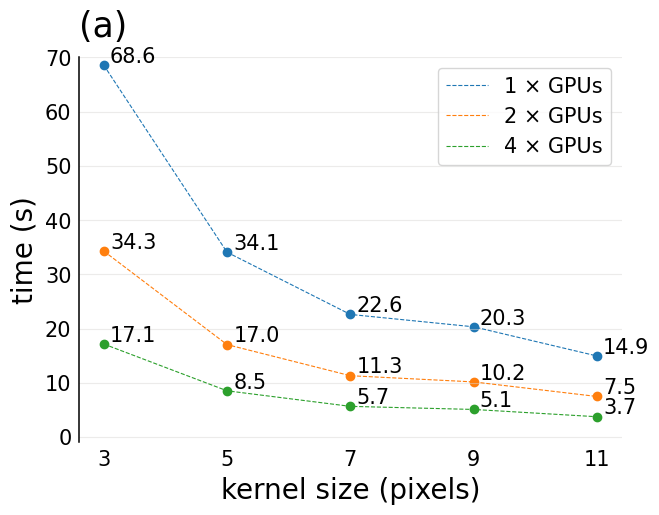

In [7]:
fig, ax = plt.subplots(figsize=(7,5)) 

def plot_ksize_test(yarr, ax):
    x = [3, 5, 7, 9, 11]
    y = np.array(yarr[:-1])

    for gpu in [1,2,4]:
        ax.scatter(x,y/gpu)
        ax.plot(x, y/gpu, linestyle='--', linewidth = 0.8, label= f'{gpu} \u00d7 GPUs')

        for i in range(len(x)):
            ax.text(x[i] + 0.1, 
                y[i]/gpu + 0.5, 
                f'{y[i]/gpu:.1f}', fontsize=15)
            
    ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)
    ax.spines[['top','right', 'bottom']].set_visible(False)
    ax.spines['left'].set_linewidth(1.1)

    ax.set_ylim(-1,70)
    ax.set_xticks(ticks=x)
    
    ax.yaxis.set_tick_params(pad=2, bottom=False, labelsize=15)
    ax.xaxis.set_tick_params(pad=2, bottom=False, labelsize=15)

    ax.set_ylabel('time (s)', fontsize=20, labelpad=5)
    ax.set_xlabel('kernel size (pixels)', fontsize=20, labelpad=5)

    ax.legend(fontsize=15)
    ax.set_title('(a)', loc='left', pad=15, fontsize=25)

plot_ksize_test(kernel_size_test, ax)

### Precision test

In [8]:
total_mae = []
for imID in tqdm(imIDs):
    img_mae = []
    mask = cv2.imread(f'{CONF.MSK_DIR}/{imID}.png', cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny((255*mask).astype(np.uint8), threshold1=128, threshold2=128)
    
    sdm_scipy = distance_transform_edt(~edges)
    sdm_scipy = sdm_scipy/sdm_scipy.max()

    for k in [3,5,7,9,11]:
        mask_tensor = torch.tensor(mask).to(torch.float32).to('cuda:0').unsqueeze(0).unsqueeze(0)
        sdm_torch = SDF.sdf(mask_tensor, K=k, imsize=512, distance='chebyshev', normalization=None)
        sdm_torch = sdm_torch[0][0].detach().cpu().numpy()
        sdm_torch = sdm_torch/sdm_torch.max()

        mae = np.round(np.mean(np.abs(sdm_scipy - sdm_torch)), 3)
        img_mae.append(mae)
    total_mae.append(img_mae)

mae = [np.mean(list(x)) for x in zip(*total_mae)]

100%|██████████| 929/929 [02:50<00:00,  5.46it/s]


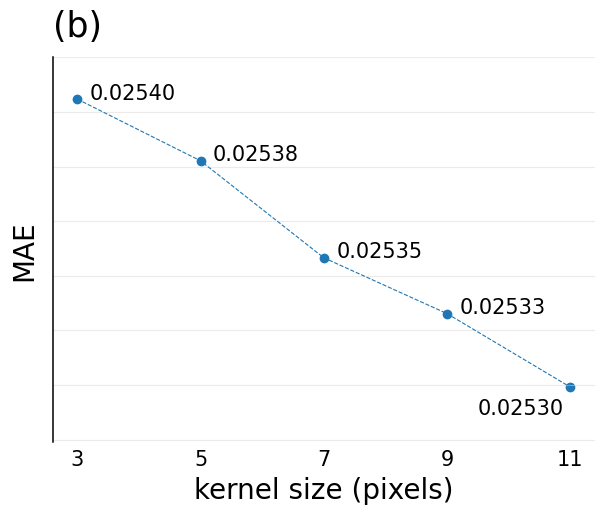

In [9]:
fig, ax = plt.subplots(figsize=(7,5))

def plot_mae(yarr, ax):
    x = [3, 5, 7, 9, 11]
    y = np.array(yarr)

    ax.scatter(x,y)
    ax.plot(x, y, linestyle='--', linewidth = 0.8)

    for i in range(len(x) - 1):
        ax.text(x[i] + 0.2, 
                y[i], 
                f'{y[i]:.5f}', fontsize=15)
    ax.text(x[4] - 1.5, y[4] - 0.00001, f'{y[4]:.5f}', fontsize=15)


    ax.set_ylim(.025279,.02542)

    ax.set_xticks(ticks=x)
    ax.set_yticklabels([])

    ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

    ax.spines[['top','right', 'bottom']].set_visible(False)
    ax.spines['left'].set_linewidth(1.1)

    ax.yaxis.set_tick_params(pad=2, bottom=False, labelsize=15)
    ax.xaxis.set_tick_params(pad=2, bottom=False, labelsize=15)

    ax.set_ylabel('MAE', fontsize=20, labelpad=5)
    ax.set_xlabel('kernel size (pixels)',fontsize=20, labelpad=5)
    ax.set_title('(b)', loc = 'left', pad = 15, fontsize = 25)

plot_mae(mae, ax)

100%|██████████| 10/10 [00:00<00:00, 14.87it/s]


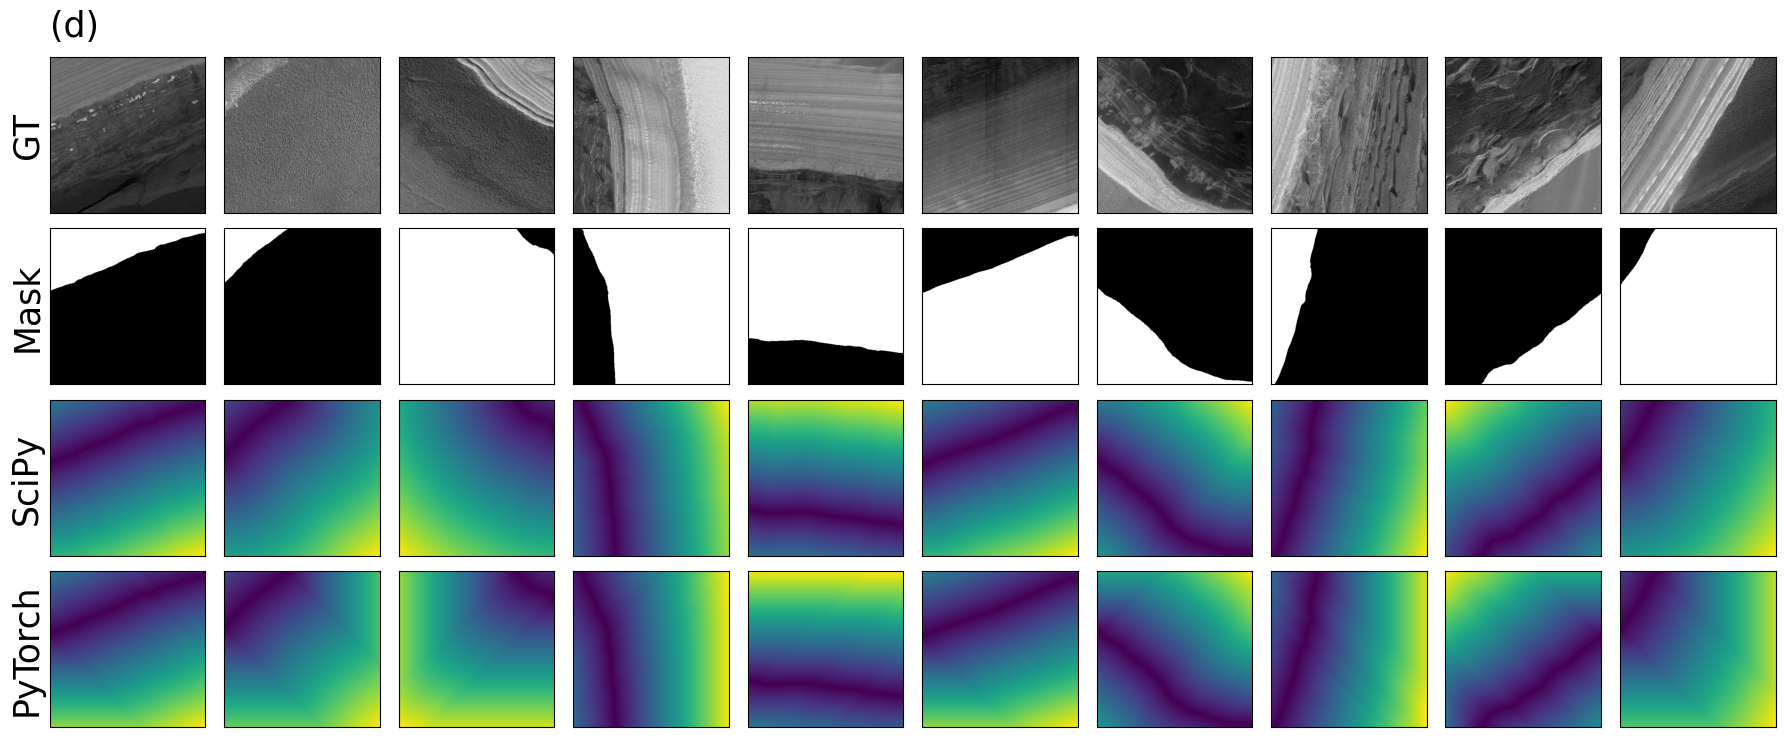

In [ ]:
num_imgs = 10
fig, ax = plt.subplots(4, num_imgs, figsize=(18,7))

def plot_smds(fig, ax, imIDs):

    imIDs = np.random.choice(imIDs, num_imgs)
    for i,imID in enumerate(tqdm(imIDs)):
        mask = cv2.imread(f'{CONF.MSK_DIR}/{imID}.png', cv2.IMREAD_GRAYSCALE)
        img = cv2.imread(f'{CONF.IMG_DIR}/{imID}.png', cv2.IMREAD_GRAYSCALE)/255
        edges = cv2.Canny((255*mask).astype(np.uint8), threshold1=128, threshold2=128)
        
        mask_tensor = torch.tensor(mask).to(torch.float32).unsqueeze(0).unsqueeze(0).to('cuda:0')
        
        sdm_scipy = distance_transform_edt(~edges)
        sdm_scipy = sdm_scipy/sdm_scipy.max()

        sdm_torch = SDF.sdf(mask_tensor, K = 7, normalization = None)
        sdm_torch = sdm_torch[0][0].detach().cpu().numpy()
        sdm_torch = sdm_torch/sdm_torch.max()

        ax1, ax2, ax3, ax4 = ax[0], ax[1], ax[2], ax[3]

        ax1[i].imshow(img, cmap = 'gray')
        ax1[i].set_xticks([])
        ax1[i].set_yticks([])

        ax2[i].imshow(mask, cmap = 'gray')
        ax2[i].set_xticks([])
        ax2[i].set_yticks([])

        ax3[i].imshow(sdm_scipy, cmap = 'viridis')
        ax3[i].set_xticks([])
        ax3[i].set_yticks([])
        
        ax4[i].imshow(sdm_torch, cmap = 'viridis')
        ax4[i].set_xticks([])
        ax4[i].set_yticks([])
        

    ax1[0].set_ylabel('GT', fontsize = 25)
    ax2[0].set_ylabel('Mask', fontsize = 25)
    ax3[0].set_ylabel('SciPy', fontsize = 25)
    ax4[0].set_ylabel('PyTorch', fontsize = 25)

    fig.tight_layout()
    fig.subplots_adjust(hspace=0.1)
    ax1[0].set_title('(d)', loc = 'left', pad = 15, fontsize = 25)
    # plt.savefig("fig2.png", format="png", bbox_inches="tight", dpi = 250)

plot_smds(fig, ax, imIDs)

### Speed Test

In [20]:
method_speed_test = []

In [21]:
# SciPy
t1 = time.time()
for imID in tqdm(imIDs):
    mask = cv2.imread(f'{CONF.MSK_DIR}/{imID}.png', cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny((255*mask).astype(np.uint8), threshold1=128, threshold2=128)
    sdm_scipy = distance_transform_edt(~edges)

t2 = time.time()
dt = t2 - t1
method_speed_test.append(('SciPy', np.round(dt, 2)))
print(f'SciPy EDT: {dt}s')

100%|██████████| 929/929 [00:08<00:00, 105.32it/s]

SciPy EDT: 8.822656869888306s


In [22]:
# PyTorch CPU
t1 = time.time()

for imID in tqdm(imIDs):
    mask = cv2.imread(f'{CONF.MSK_DIR}/{imID}.png', cv2.IMREAD_GRAYSCALE)
    mask_tensor = torch.from_numpy(mask).to(torch.float32).unsqueeze(0).unsqueeze(0)
    sdm_torch = SDF.sdf(mask_tensor, K=7)

t2 = time.time()
dt = t2 - t1
method_speed_test.append(('CPU', np.round(dt, 2)))
print(f'PyTorch CPU: {dt}s')

100%|██████████| 929/929 [03:31<00:00,  4.39it/s]

PyTorch CPU: 211.58819937705994s


In [ ]:
# PyTorch CPU-16
t1 = time.time()

mask_batch = []
imID_batch = []
for i, imID in enumerate(tqdm(imIDs), start=1):
    mask = cv2.imread(f'{CONF.MSK_DIR}/{imID}.png', cv2.IMREAD_GRAYSCALE)
    mask_batch.append(mask) 
    imID_batch.append(imID)
    if i%16 == 0 or i == len(imIDs):
        mask_batch = np.stack(mask_batch, axis=0)
        mask_batch_tensor = torch.from_numpy(mask_batch).to(torch.float32).unsqueeze(1)

        SDMs = SDF.sdf(mask_batch_tensor, K=7)

        mask_batch = []
        imID_batch = []

t2 = time.time()
dt = t2 - t1
method_speed_test.append(('CPU-16', np.round(dt, 2)))
print(f'PyTorch CPU batched: {dt}s')

100%|██████████| 929/929 [02:39<00:00,  5.83it/s]

PyTorch CPU batched: 159.42235589027405s


In [24]:
# PyTorch GPU
t1 = time.time()

for imID in tqdm(imIDs):
    mask = cv2.imread(f'{CONF.MSK_DIR}/{imID}.png', cv2.IMREAD_GRAYSCALE)
    mask_tensor = torch.from_numpy(mask).to(torch.float32).unsqueeze(0).unsqueeze(0).to('cuda:0')
    sdm_torch = SDF.sdf(mask_tensor, K = 7)

t2 = time.time()
dt = t2 - t1
method_speed_test.append(('GPU', np.round(dt, 2)))
print(f'PyTorch GPU: {dt}s')

100%|██████████| 929/929 [00:23<00:00, 39.56it/s]

PyTorch GPU: 23.485979557037354s


In [ ]:
# PyTorch GPU-16
t1 = time.time()
mask_batch = []
imID_batch = []

for i, imID in enumerate(tqdm(imIDs), start=1):
    mask = cv2.imread(f'{CONF.MSK_DIR}/{imID}.png', cv2.IMREAD_GRAYSCALE)
    mask_batch.append(mask) 
    imID_batch.append(imID)
    if i%16 == 0 or i == len(imIDs):
        mask_batch = np.stack(mask_batch, axis=0)
        mask_batch_tensor = torch.from_numpy(mask_batch).to(torch.float32).unsqueeze(1)
        mask_batch_tensor = mask_batch_tensor.to('cuda:0')

        SDMs = SDF.sdf(mask_batch_tensor, K = 7)

        mask_batch = []
        imID_batch = []
t2 = time.time()
dt = t2 - t1
method_speed_test.append(('GPU-16', np.round(dt, 2)))
print(f'PyTorch GPU batch: {dt}s')

100%|██████████| 929/929 [00:05<00:00, 175.43it/s]

PyTorch GPU batch: 5.29566764831543s


In [ ]:
# PyTorch 4xGPU-16
method_speed_test.append(('4xGPU-16', np.round(method_speed_test[-1][-1]/4, 1)))

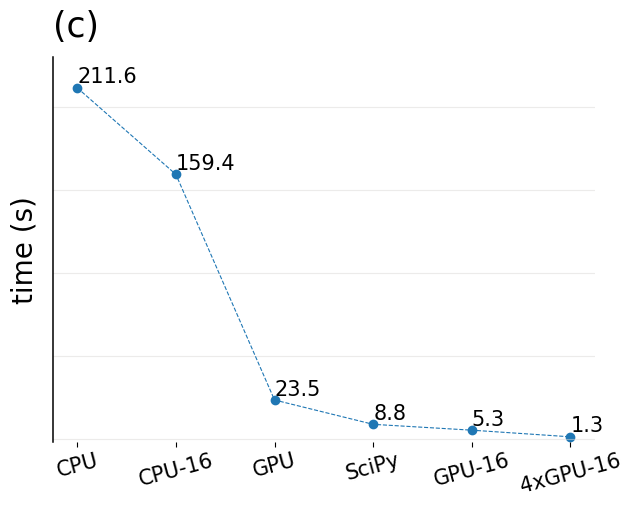

In [42]:
fig, ax = plt.subplots(figsize=(7,5))

def plot_speed_test(ax, arr):
    arr = sorted(arr, key=lambda x: x[1], reverse=True)

    x = [item[0] for item in arr]
    y = [item[1] for item in arr]
    x_i = list(range(len(x)))

    ax.scatter(x,y)
    ax.plot(x, y, linestyle='--', linewidth = 0.8)

    for i in range(len(x)):
        ax.text(x_i[i], y[i] + 3, f'{y[i]:.1f}', fontsize=15)

    ax.set_ylim(-2, 230)
    # ax.set_xlim(2,12)
    ax.set_yticklabels([])

    ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)

    ax.spines[['top','right', 'bottom']].set_visible(False)
    ax.spines['left'].set_linewidth(1.1)

    ax.yaxis.set_tick_params(pad=2, labeltop=False, labelbottom=True, bottom=False, labelsize=15)
    ax.xaxis.set_tick_params(pad=2, labelsize=15, labelrotation=15)

    ax.set_ylabel('time (s)', fontsize=20, labelpad=5)
 
    ax.set_title('(c)', loc = 'left', pad = 15, fontsize = 25)

plot_speed_test(ax, method_speed_test)

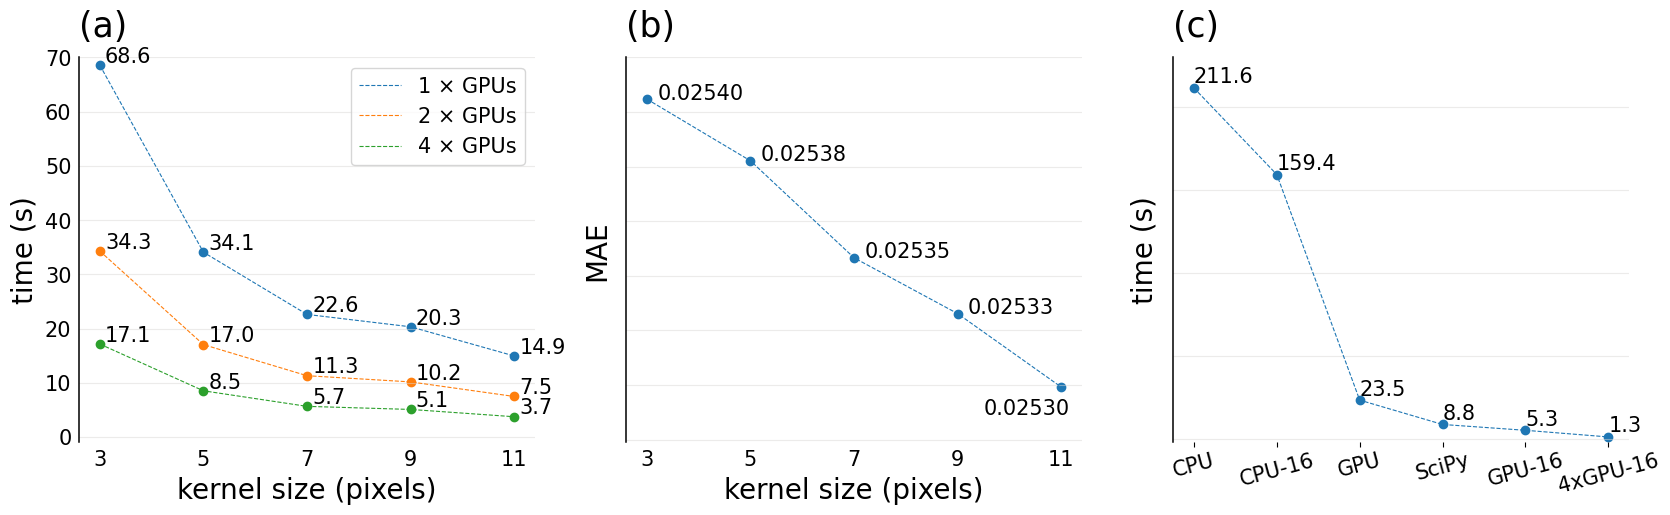

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(20,5))
plot_ksize_test(kernel_size_test, ax[0])
plot_mae(mae, ax[1])
plot_speed_test(ax[2], method_speed_test)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2)
# plt.savefig("fig1.png", format="png", bbox_inches="tight", dpi = 250)